# Data retrieval

The source data which we will be working on will be working on text data from news articles on technology, sports and world  which we have retrieved from inshorts, a website that gives us short, 60-word news articles on a wide variety of topics, and they even have an app for it!

We will be using this information to extract news articles by leveraging the BeautifulSoup and requests libraries. Let’s first load up the following dependencies.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

We will now build a function which will leverage requests to access and get the HTML content from the landing pages of each of the three news categories. Then, we will use BeautifulSoup to parse and extract the news headline and article textual content for all the news articles in each category. We find the content by accessing the specific HTML tags and classes, where they are present 

In [3]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

It is pretty clear that we extract the news headline, article text and category and build out a data frame, where each row corresponds to a specific news article. We will now invoke this function and build our dataset.

In [4]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Additional tax deduction of ₹1.5 lakh on inter...,"While presenting the Union Budget, Finance Min...",technology
1,2 crore villagers made literate in digital tec...,"Presenting her maiden Union Budget on Friday, ...",technology
2,Xiaomi uses Apple's 'Memoji' ad to promote its...,Chinese smartphone maker Xiaomi uploaded Apple...,technology
3,Google apologises 7 months after revealing NZ ...,Google on Friday apologised for violating New ...,technology
4,Apple Co-founder Steve Jobs was an a*****e at ...,World's second richest person and Microsoft Co...,technology
5,Yet to meet any person with design sense like ...,Microsoft Co-founder and world's second riches...,technology
6,US okays $2.25 bn SoftBank investment in GM-ba...,The Committee on Foreign Investment in the US ...,technology
7,Alipay adds beauty filters to its face recogni...,Alibaba's e-wallet affiliate Alipay has added ...,technology
8,4 drones spray-paint huge graffiti after flyin...,An Italian design firm collected drawings from...,technology
9,Govt planning to monitor internet via centrali...,Telecom Minister Ravi Shankar Prasad has infor...,technology


We, now, have a neatly formatted dataset of news articles and you can quickly check the total number of news articles with the following code.

In [6]:
news_df.news_category.value_counts()

world         25
technology    24
sports        23
Name: news_category, dtype: int64

# Text Wrangling and Pre-processing

There are usually multiple steps involved in cleaning and pre-processing textual data.

In this section, I will highlight some of the most important steps which are used heavily in Natural Language Processing (NLP) pipelines and frequently used in NLP projects. We will be leveraging a fair bit of nltk and spacy, both state-of-the-art libraries in NLP. 

In [19]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

nlp = spacy.load('en', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Remove HTML tags

Often, unstructured text contains a lot of noise, especially if you use techniques like web or screen scraping. HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.

In [20]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

## Remove accented characters

Usually in any text corpus, you might be dealing with accented characters/letters, especially if you only want to analyze the English language. Hence, we need to make sure that these characters are converted and standardized into ASCII characters. A simple example — converting é to e.

In [21]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expand contractions

Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, do not to don’t and I would to I’d. Converting each contraction to its expanded, original form helps with text standardization.

In [22]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

## Remove special characters

Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructured text. Usually, simple regular expressions (regexes) can be used to remove them.

In [28]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

## Text stemming

The reverse process of obtaining the base form of a word from its inflected form is known as stemming. Stemming helps us in standardizing words to their base or root stem, irrespective of their inflections, which helps many applications like classifying or clustering text, and even in information retrieval. Let’s see the popular Porter stemmer.

In [23]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Text lemmatization

Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem. The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary. Both nltk and spacy have excellent lemmatizers. We will be using spacy here.

In [24]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

## Remove stopwords

Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

There is no universal stopword list, but we use a standard English language stopwords list from nltk.

In [32]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Building a text normalizer

Bringing it all together — While we can definitely keep going with more techniques like correcting spelling, grammar and so on, let’s now bring everything we learnt together and chain these operations to build a text normalizer to pre-process text data.

In [33]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize news articles

We will first combine the news headline and the news article text together to form a document for each piece of news. Then, we will pre-process them.

In [34]:
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

In [35]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': "2 crore villagers made literate in digital technology: Sitharaman. Presenting her maiden Union Budget on Friday, Finance Minister Nirmala Sitharaman announced that 2 crore villagers have been made literate in digital technology under PM's digital literacy program. She added that 80 livelihood business incubators and 20 technology business incubators will be set up in 2019-20 under ASPIRE to develop 75,000 skilled entrepreneurs in agro-rural industries.",
 'clean_text': 'crore villager make literate digital technology sitharaman present maiden union budget friday finance minister nirmala sitharaman announce crore villager make literate digital technology pms digital literacy program add livelihood business incubator technology business incubator set aspire develop skilled entrepreneur agro rural industry'}

# Save the news articles

Thus, you can see how our text pre-processor helps in pre-processing our news articles! After this, you can save this dataset to disk if needed, so that you can always load it up later for future analysis.

In [36]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

Knowledge about the structure and syntax of language is helpful in many areas like text processing, annotation, and parsing for further operations such as text classification or summarization. Typical parsing techniques for understanding text syntax are mentioned below

# Tagging Parts of Speech

Parts of speech (POS) are specific lexical categories to which words are assigned, based on their syntactic context and role. Usually, words can fall into one of the following major categories.

- N(oun): This usually denotes words that depict some object or entity, which may be living or nonliving. Some examples would be fox , dog , book , and so on. The POS tag symbol for nouns is N.


- V(erb): Verbs are words that are used to describe certain actions, states, or occurrences. There are a wide variety of further subcategories, such as auxiliary, reflexive, and transitive verbs (and many more). Some typical examples of verbs would be running , jumping , read , and write . The POS tag symbol for verbs is V.


- Adj(ective): Adjectives are words used to describe or qualify other words, typically nouns and noun phrases. The phrase beautiful flower has the noun (N) flower which is described or qualified using the adjective (ADJ) beautiful . The POS tag symbol for adjectives is ADJ .


- Adv(erb): Adverbs usually act as modifiers for other words including nouns, adjectives, verbs, or other adverbs. The phrase very beautiful flower has the adverb (ADV) very , which modifies the adjective (ADJ) beautiful , indicating the degree to which the flower is beautiful. The POS tag symbol for adverbs is ADV.

Besides these four major categories of parts of speech , there are other categories that occur frequently in the English language. These include pronouns, prepositions, interjections, conjunctions, determiners, and many others. Furthermore, each POS tag like the noun (N) can be further subdivided into categories like singular nouns (NN), singular proper nouns (NNP), and plural nouns (NNS).

The process of classifying and labeling POS tags for words called parts of speech tagging or POS tagging . POS tags are used to annotate words and depict their POS, which is really helpful to perform specific analysis, such as narrowing down upon nouns and seeing which ones are the most prominent, word sense disambiguation, and grammar analysis. We will be leveraging both nltk and spacy which usually use the Penn Treebank notation for POS tagging.



In [37]:
news_df = pd.read_csv('news.csv')

In [38]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [39]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,2,CD,NUM
1,crore,NN,NOUN
2,villagers,NNS,NOUN
3,made,VBN,VERB
4,literate,JJ,ADJ
5,in,IN,ADP
6,digital,JJ,ADJ
7,technology,NN,NOUN
8,:,:,PUNCT
9,Sitharaman,NN,NOUN


In [67]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,2,CD
1,crore,NN
2,villagers,NNS
3,made,VBD
4,literate,NN
5,in,IN
6,digital,JJ
7,technology:,NN
8,Sitharaman,NNP


# Shallow Parsing or Chunking Text

groups of words make up phrases. There are five major categories of phrases:

- Noun phrase (NP): These are phrases where a noun acts as the head word. Noun phrases act as a subject or object to a verb.


- Verb phrase (VP): These phrases are lexical units that have a verb acting as the head word. Usually, there are two forms of verb phrases. One form has the verb components as well as other entities such as nouns, adjectives, or adverbs as parts of the object.


- Adjective phrase (ADJP): These are phrases with an adjective as the head word. Their main role is to describe or qualify nouns and pronouns in a sentence, and they will be either placed before or after the noun or pronoun.


- Adverb phrase (ADVP): These phrases act like adverbs since the adverb acts as the head word in the phrase. Adverb phrases are used as modifiers for nouns, verbs, or adverbs themselves by providing further details that describe or qualify them.


- Prepositional phrase (PP): These phrases usually contain a preposition as the head word and other lexical components like nouns, pronouns, and so on. These act like an adjective or adverb describing other words or phrases.


Shallow parsing, also known as light parsing or chunking , is a popular natural language processing technique of analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. 



We will leverage the conll2000 corpus for training our shallow parser model. This corpus is available in nltk with chunk annotations and we will be using around 10K records for training our model. A sample annotated sentence is depicted as follows.

In [40]:
from nltk.corpus import conll2000
data = conll2000.chunked_sents()

train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


From the preceding output, you can see that our data points are sentences that are already annotated with phrases and POS tags metadata that will be useful in training our shallow parser model. We will leverage two chunking utility functions, tree2conlltags , to get triples of word, tag, and chunk tags for each token, and conlltags2tree to generate a parse tree from these token triples. We will be using these functions to train our parser. A sample is depicted below.

In [51]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [52]:
import nltk
from nltk.corpus import conll2000
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.chunk import ne_chunk
from nltk import pos_tag

In [53]:
tree = conlltags2tree(wtc) 
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


We will now define a function conll_tag_ chunks() to extract POS and chunk tags from sentences with chunked annotations and a function called combined_taggers() to train multiple taggers with backoff taggers (e.g. unigram and bigram taggers)

In [54]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

We will now define a class NGramTagChunker that will take in tagged sentences as training input, get their (word, POS tag, Chunk tag) WTC triples, and train a BigramTagger with a UnigramTagger as the backoff tagger. We will also define a parse() function to perform shallow parsing on new sentences

We will use this class to train on the conll2000 chunked train_data and evaluate the model performance on the test_data

In [68]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

In [69]:
ntc = NGramTagChunker(train_data)
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


Our chunking model gets an accuracy of around 90% which is quite good! Let’s now leverage this model to shallow parse and chunk our sample news article headline which we used earlier, “US unveils world’s most powerful supercomputer, beats China”.

Thus you can see it has identified two noun phrases (NP) and one verb phrase (VP) in the news article. Each word’s POS tags are also visible.

In [70]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP 2/CD crore/NN villagers/NNS)
  (VP made/VBD)
  (NP literate/NN)
  (PP in/IN)
  (NP digital/JJ technology:/NN Sitharaman/NNP))


# Constituency parsing

Constituent-based grammars are used to analyze and determine the constituents of a sentence. These grammars can be used to model or represent the internal structure of sentences in terms of a hierarchically ordered structure of their constituents. Each and every word usually belongs to a specific lexical category in the case and forms the head word of different phrases. These phrases are formed based on rules called phrase structure rules.

Phrase structure rules form the core of constituency grammars, because they talk about syntax and rules that govern the hierarchy and ordering of the various constituents in the sentences. These rules cater to two things primarily.

They determine what words are used to construct the phrases or constituents.
They determine how we need to order these constituents together.
The generic representation of a phrase structure rule is S → AB , which depicts that the structure S consists of constituents A and B , and the ordering is A followed by B . While there are several rules (refer to Chapter 1, Page 19: Text Analytics with Python, if you want to dive deeper), the most important rule describes how to divide a sentence or a clause. The phrase structure rule denotes a binary division for a sentence or a clause as S → NP VP where S is the sentence or clause, and it is divided into the subject, denoted by the noun phrase (NP) and the predicate, denoted by the verb phrase (VP).

A constituency parser can be built based on such grammars/rules, which are usually collectively available as context-free grammar (CFG) or phrase-structured grammar. The parser will process input sentences according to these rules, and help in building a parse tree.



We will be using nltk and the StanfordParser here to generate parse trees.

In [76]:
# set java path
import os
java_path = r'C:\Program Files\Java\jre-10.0.1\bin\java.exe'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='C:/Users/sanke/Desktop/New resume July 2019/Github Notebooks/stanford-parser-full-2018-10-17/stanford-parser.jar',
                   path_to_models_jar='C:/Users/sanke/Desktop/New resume July 2019/Github Notebooks/stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

(ROOT
  (S
    (NP (CD 2) (JJ crore) (NNS villagers))
    (VP
      (VBD made)
      (NP
        (NP
          (NP (NN literate))
          (PP (IN in) (NP (JJ digital) (NN technology))))
        (: :)
        (NP (NNP Sitharaman))))))


# Dependency parsing

In dependency parsing, we try to use dependency-based grammars to analyze and infer both structure and semantic dependencies and relationships between tokens in a sentence. The basic principle behind a dependency grammar is that in any sentence in the language, all words except one, have some relationship or dependency on other words in the sentence. The word that has no dependency is called the root of the sentence. The verb is taken as the root of the sentence in most cases. All the other words are directly or indirectly linked to the root verb using links , which are the dependencies.

In [79]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---2[nummod]--->[]
--------
['2']<---crore[compound]--->[]
--------
['crore']<---villagers[nsubj]--->[]
--------
['villagers']<---made[ROOT]--->['literate', 'in', ':']
--------
[]<---literate[dobj]--->[]
--------
[]<---in[prep]--->['technology']
--------
[]<---digital[amod]--->[]
--------
['digital']<---technology[pobj]--->[]
--------
[]<---:[punct]--->[]
--------
[]<---Sitharaman[ROOT]--->[]
--------


In [80]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

We can also leverage nltk and the StanfordDependencyParser to visualize and build out the dependency tree. We showcase the dependency tree both in its raw and annotated form as follows.

In [82]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='C:/Users/sanke/Desktop/New resume July 2019/Github Notebooks/stanford-parser-full-2018-10-17/stanford-parser.jar',
                               path_to_models_jar='C:/Users/sanke/Desktop/New resume July 2019/Github Notebooks/stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')    
result = list(sdp.raw_parse(sentence))  
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

(made
  (villagers 2 crore)
  (literate (technology in digital) Sitharaman))


# Named Entity Recognition

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. These entities are known as named entities , which more specifically refer to terms that represent real-world objects like people, places, organizations, and so on, which are often denoted by proper names. A naive approach could be to find these by looking at the noun phrases in text documents. Named entity recognition (NER) , also known as entity chunking/extraction , is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.

SpaCy has some excellent capabilities for named entity recognition. Let’s try and use it on one of our sample news articles.

In [86]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

In [87]:
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(2, 'CARDINAL'), (Union, 'ORG'), (Budget, 'ORG'), (Friday, 'DATE'), (Finance, 'ORG'), (Nirmala, 'PERSON'), (Sitharaman, 'PERSON'), (2, 'CARDINAL'), (80, 'CARDINAL'), (20, 'CARDINAL'), (2019, 'DATE'), (-, 'DATE'), (20, 'DATE'), (ASPIRE, 'ORG'), (75,000, 'CARDINAL')]


In [88]:
displacy.render(sentence_nlp, style='ent', jupyter=True)

Let’s now find out the most frequent named entities in our news corpus! For this, we will build out a data frame of all the named entities and their types using the following code.

In [89]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

We can now transform and aggregate this data frame to find the top occuring entities and types.

In [90]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,India,New Zealand,World Cup,Iran,Indian,6,Google,Virat Kohli,Trump,Apple,Taliban,Alexa,Dhoni,second
Entity Type,GPE,GPE,GPE,EVENT,GPE,NORP,CARDINAL,ORG,PERSON,ORG,ORG,ORG,ORG,GPE,ORDINAL
Frequency,28,23,9,9,8,8,7,6,6,6,5,5,5,5,5


We can also group by the entity types to get a sense of what types of entites occur most in our news corpus.

In [91]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,GPE,PERSON,DATE,CARDINAL,NORP,ORDINAL,EVENT,FAC,PRODUCT,LAW,TIME,MONEY,PERCENT,LOC
Frequency,170,142,125,65,60,46,19,17,8,7,6,5,4,3,3


Another nice NER tagger is the StanfordNERTagger available from the nltk interface.

Stanford’s Named Entity Recognizer is based on an implementation of linear chain Conditional Random Field (CRF) sequence models. Unfortunately this model is only trained on instances of PERSON, ORGANIZATION and LOCATION types. Following code can be used as a standard workflow which helps us extract the named entities using this tagger and show the top named entities and their types (extraction differs slightly from spacy).

In [98]:
from nltk.tag import StanfordNERTagger
import os
java_path = r'C:\Program Files\Java\jre-10.0.1\bin\java.exe'
os.environ['JAVAHOME'] = java_path

sn = StanfordNERTagger('C:/Users/sanke/Desktop/New resume July 2019/Github Notebooks/stanford-ner-2014-08-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='C:/Users/sanke/Desktop/New resume July 2019/Github Notebooks/stanford-ner-2014-08-27/stanford-ner.jar')

ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

c:\users\sanke\miniconda3\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [99]:
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [100]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,US,LOCATION,27
1,India,LOCATION,19
2,New Zealand,LOCATION,11
3,Iran,LOCATION,8
4,Google,ORGANIZATION,7
5,Trump,PERSON,5
6,Taliban,ORGANIZATION,5
7,Alexa,PERSON,5
8,Rohit Sharma,PERSON,4
9,Dhoni,PERSON,4


In [101]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,PERSON,159
1,LOCATION,144
2,ORGANIZATION,81


# Emotion and Sentiment Analysis

The AFINN lexicon is perhaps one of the simplest and most popular lexicons that can be used extensively for sentiment analysis. 


The current version of the lexicon is AFINN-en-165. txt and it contains over 3,300+ words with a polarity score associated with each word. 

The following code computes sentiment for all our news articles and shows summary statistics of general sentiment per news category.

In [123]:
from afinn import Afinn

af = Afinn()

In [124]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [125]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                
                        count      mean       std   min   25%  50%  75%   max
news_category                                                                
sports                   23.0  3.739130  5.994068  -6.0  0.00  3.0  6.5  17.0
technology               24.0 -0.583333  5.977615 -14.0 -3.25  0.0  2.0  13.0
world                    25.0 -5.000000  4.663690 -15.0 -8.00 -4.0 -2.0   2.0

We can get a good idea of general sentiment statistics across different news categories. Looks like the average sentiment is very positive in sports and reasonably negative in technology! Let’s look at some visualizations now.

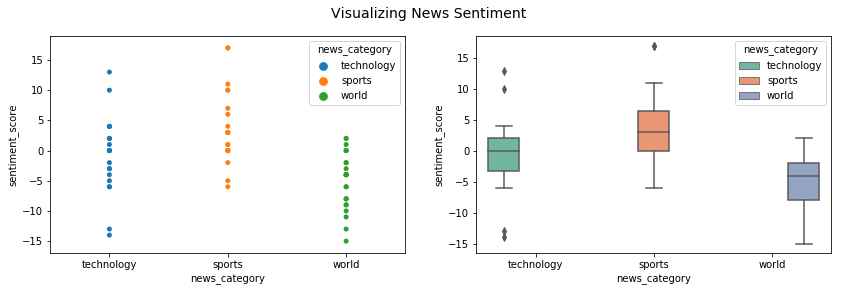

In [126]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

We can see that the spread of sentiment polarity is much higher in sports and world as compared to technology where a lot of the articles seem to be having a negative polarity. We can also visualize the frequency of sentiment labels.

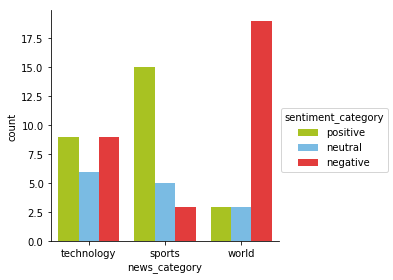

In [127]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

No surprises here that technology has the most number of negative articles and world the most number of positive articles. Sports might have more neutral articles due to the presence of articles which are more objective in nature (talking about sporting events without the presence of any emotion or feelings). Let’s dive deeper into the most positive and negative sentiment news articles for technology news.

In [128]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 13)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -14)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Google on Friday apologised for violating New Zealand's name suppression rules in December 2018 after it unintentionally disclosed the name of a 27-year-old man accused of murder. It added it has disabled the Trends feature in New Zealand, which was responsible for the disclosure. The accused has pleaded not guilty to the murder of a 22-year-old British tourist, Grace Millane. 

Most Positive Tech News Article: Microsoft Co-founder and world's second richest person Bill Gates said he's "yet to meet any person who could rival Apple Co-founder Steve Jobs in having a sense of design of, 'Oh, this is good. This is not good'." He added that Jobs was really good at picking talent and hyper-motivating that talent. "Even when he failed, he succeeded," Gates added.


In [129]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 2)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -15)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Britain's ambassador in the US Kim Darroch has described President Donald Trump's administration as "inept" and "uniquely dysfunctional", according to a Daily Mail report. Darroch reportedly said Trump's presidency could "crash and burn" and "end in disgrace". He also reportedly said that the "vicious infighting and chaos" inside the White House, dismissed by Trump as "fake news", was "mostly true".

Most Positive World News Article: The government has raised the foreign aid to Nepal from ₹750 crore last year to ₹1,050 crore in the 2019-20 Budget, an increase of 40%. For the Maldives, the allocation was raised to ₹576 crore, from ₹440 crores in 2018-2019. The aid to African countries saw an increase from ₹330 crore last year to ₹450 crore this year. 


## Sentiment Analysis with TextBlob

TextBlob is another excellent open-source library for performing NLP tasks with ease, including sentiment analysis. It also an a sentiment lexicon (in the form of an XML file) which it leverages to give both polarity and subjectivity scores. Typically, the scores have a normalized scale as compare to Afinn. The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. Let’s use this now to get the sentiment polarity and labels for each news article and aggregate the summary statistics per news category

In [136]:
from textblob import TextBlob

sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [137]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           \
                        count      mean       std   min     25%    50%   
news_category                                                            
sports                   23.0  0.149043  0.123782 -0.12  0.0565  0.184   
technology               24.0  0.036292  0.113075 -0.20 -0.0065  0.044   
world                    25.0  0.021280  0.159617 -0.26 -0.0700  0.023   

                               
                   75%    max  
news_category                  
sports         0.20300  0.364  
technology     0.10625  0.287  
world          0.13300  0.322

Looks like the average sentiment is the most positive in world and least positive in technology! However, these metrics might be indicating that the model is predicting more articles as positive. Let’s look at the sentiment frequency distribution per news category.

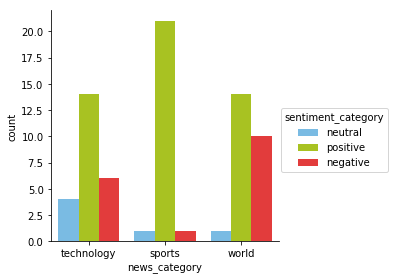

In [138]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

There definitely seems to be more positive articles across the news categories here as compared to our previous model. However, still looks like technology has the most negative articles and world, the most positive articles similar to our previous analysis. Let’s now do a comparative analysis and see if we still get similar articles in the most positive and negative categories for world news.

In [143]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.322)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.26)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: A man was wrongly taken off life support in Chicago, US, after a family mistakenly thought he was their relative and gave its consent, a lawsuit claimed. The man, who was found injured and unconscious underneath a car, was wrongly identified by the police as Alfonso Bennett. The mistake emerged when the real Alfonso Bennett showed up at a barbecue.

Most Positive World News Article: California was hit by its strongest earthquake in two decades on Friday, a 7.1-magnitude tremor that shook buildings and cut power supplies in parts of Los Angeles but did not cause any deaths. The quake struck near the city of Ridgecrest, US seismologists said, and follows a 6.4-magnitude quake that hit the same area the day before.


Finally, we can even evaluate and compare between these two models as to how many predictions are matching and how many are not (by leveraging a confusion matrix which is often used in classification). We leverage our nifty model_evaluation_utils module for this.

In [145]:
import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

C:\Users\sanke\model_evaluation_utils.py:76: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Users\sanke\model_evaluation_utils.py:78: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


Predicted:                 
                   negative neutral positive
Actual: negative         10       1       20
        neutral           4       2        8
        positive          3       3       21

In the preceding table, the ‘Actual’ labels are predictions from the Afinn sentiment analyzer and the ‘Predicted’ labels are predictions from TextBlob. Looks like our previous assumption was correct. TextBlob definitely predicts several neutral and negative articles as positive. Overall most of the sentiment predictions seem to match, which is good!